# Stochastic, Mini batch e Full batch Gradient Descent
In questo notebook faremo un confronto tra le tre varianti dell'algoritmo di ottimizzazione Gradient Descent
 * **Full Batch**: Il gradient descent utilizza tutti gli esempi per correggere i coefficienti.
 * **Stochastic**: Il gradient descent utilizza un solo esempio per volta per correggere i coefficienti.
 * **Mini Batch**: Il gradient descent utilizza un determinato numero di esempi per volta per coreggere i coefficienti.
 
Per questo esempio utilizzeremo il dataset [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist), un dataset contenente immagini capi di abbigliamento in formato 28x28 correttamente classificati, creato dalla popolare piattaforma di e-commerce Zalando.

## Importiamo i Moduli

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from time import time

## Preparazione dei dati
Piuttosto che scaricare i files in formato binario dalla repository, possiamo caricare il dataset utilizzando tensorflow-datasets

In [2]:
dataset = tfds.load('fashion_mnist', split='train', shuffle_files=True)

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteOBVJFC/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.0.incompleteOBVJFC/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.0. Subsequent calls will reuse this data.


Il dataset contiene 10 diversi tipi di capi di abbigliamento, elencati nella lista qui sotto, il target è già codificato con un numero che indica la posizione del target all'interno di questa lista.

In [3]:
INDEX_TO_LABEL = ["T-shirt/top","Pantalone","Pullover","Vestito","Cappotto","Sandalo","Maglietta","Sneaker","Borsa","Stivaletto"]

Definiamo una funzione per importare il dataset all'interno di due array numpy, contenenti rispettivamente le immagini e le classi.

In [4]:
def load_data(dataset, num_samples=None):
  images = []
  labels = []

  for i, example in enumerate(tfds.as_numpy(dataset)):

    if(num_samples!=None and i>=num_samples):
      break

    images.append(example["image"])
    labels.append(example["label"])

  images = np.array(images)
  labels = np.array(labels)

  return images, labels

In [5]:
images, labels = load_data(dataset)
num_classes = np.unique(labels).shape[0]
print("Numero di esempi: %d" % images.shape[0])
print("Dimensioni immagine: %s" % str(images[0].shape))
print("Classi = %d %s" % (num_classes, np.unique(labels)))

Numero di esempi: 60000
Dimensioni immagine: (28, 28, 1)
Classi = 10 [0 1 2 3 4 5 6 7 8 9]


Dato che una singola osservazione è una matrice, dobbiamo eseguire il *flattening*  per codificarla in un unico vettore. Per farlo possiamo utilizzare il metodo <span style="font-family: Monaco">reshape</span>.

In [6]:
X = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
y = tf.one_hot(labels, num_classes).numpy()

Ora dividiamo il dataset in Train Set e Test Set.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("Train set: %d esempi - Test set: %d esempi" % (X_train.shape[0], X_test.shape[0]))

Train set: 42000 esempi - Test set: 18000 esempi


Ogni pixel dell'immagine ha un valore che va da 0 a 255, eseguiamo la normalizzazione per ridurre questi valori in una scala da 0 a 1.

In [8]:
X_train = X_train/255
X_test = X_test/255

Per assicurarci di aver fatto tutto correttamente, proviamo a visualizzare un'immagine con il corrispondente target.

T-shirt/top


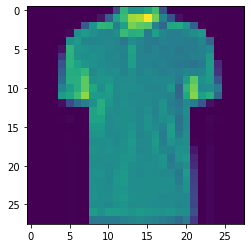

In [9]:
plt.imshow(X_train[0].reshape(28,28))
print(INDEX_TO_LABEL[np.argmax(y_train[0])])

## Costruiamo la Rete Neurale
Definamo una funzione che ci ritornerà la nostra rete neurale già compilata utilizzando come algoritmo di ottimizzazione il Gradient Descent.

In [10]:
def build_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(512, activation='relu', input_shape=[X_train.shape[1]]))
  model.add(tf.keras.layers.Dense(256, activation='relu'))
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

  return model

Defiiamo anche una funzione per creare un grafico dell'evoluzione della Log Loss durante le varie epoche dell'addestramento.

In [15]:
def plot_loss_chart(title, figsize=(14,10), validation=True):

  plt.figure(figsize=figsize)
  plt.title(title)
  plt.xlabel("Epoca")
  plt.ylabel("Log-Loss")
  
  plt.plot(model.history.history['loss'], label="Training Loss")

  if(validation):
    plt.plot(model.history.history['val_loss'], label="Validation Loss")

  plt.legend()

## Full batch Gradient Descent
Cominciamo dal Full batch Gradient Descent. Creiamo il modello.

In [12]:
model = build_model()

Il Full Batch Gradient Descent utilizza tutti i dati del Train Set per ogni epoca, per utilizzarlo non dobbiamo far altro che specificare all'interno del metodo  <span style="font-family: Monaco">fit</span> che la dimensione di un batch deve essere pari al numero di osservazioni nel Tran Set, in tal modo l'algoritmo di ottimizzazione utilizzerà un unico batch con tutte le osservazioni ad ogni iterazione.
<br>
Per poter costruire un grafico della funzione di costo ad ogni epoca dobbiamo tener traccia di questi valori, per farlo possiamo utilizzare un History Callback.

In [ ]:
start_at = time()
model.fit(X_train, y_train, batch_size=X_train.shape[0],
          validation_data=(X_test, y_test), validation_batch_size = X_test.shape[0], 
          epochs=100, callbacks=[tf.keras.callbacks.History()])
exec_time = time() - start_at

print("Tempo di addestramento: %d minuti e %d secondi" % (exec_time/60, exec_time%60))

Epoch 1/100
1/1 [==============================] - 0s 161ms/step - loss: 2.3673 - accuracy: 0.1123 - val_loss: 2.3448 - val_accuracy: 0.1206
Epoch 2/100
1/1 [==============================] - 0s 72ms/step - loss: 2.3412 - accuracy: 0.1190 - val_loss: 2.3218 - val_accuracy: 0.1287
Epoch 3/100
1/1 [==============================] - 0s 72ms/step - loss: 2.3184 - accuracy: 0.1283 - val_loss: 2.3013 - val_accuracy: 0.1388
Epoch 4/100
1/1 [==============================] - 0s 75ms/step - loss: 2.2979 - accuracy: 0.1383 - val_loss: 2.2827 - val_accuracy: 0.1494
Epoch 5/100
1/1 [==============================] - 0s 69ms/step - loss: 2.2794 - accuracy: 0.1492 - val_loss: 2.2656 - val_accuracy: 0.1608
Epoch 6/100
1/1 [==============================] - 0s 76ms/step - loss: 2.2624 - accuracy: 0.1601 - val_loss: 2.2497 - val_accuracy: 0.1717
Epoch 7/100
1/1 [==============================] - 0s 77ms/step - loss: 2.2465 - accuracy: 0.1723 - val_loss: 2.2347 - val_accuracy: 0.1812
Epoch 8/100
1/1 [==

I risultati del modello sono piuttosto scarsi, perché le 100 epoche non erano sufficenti a far convergere il modello, infatti con ulteriori epoche il modello avrebbe continuato a migliorare.
<br>
Utilizziamo i valori della funzione di costo raccolti per visualizzare la sua variazione a ogni epoche su di un grafico.

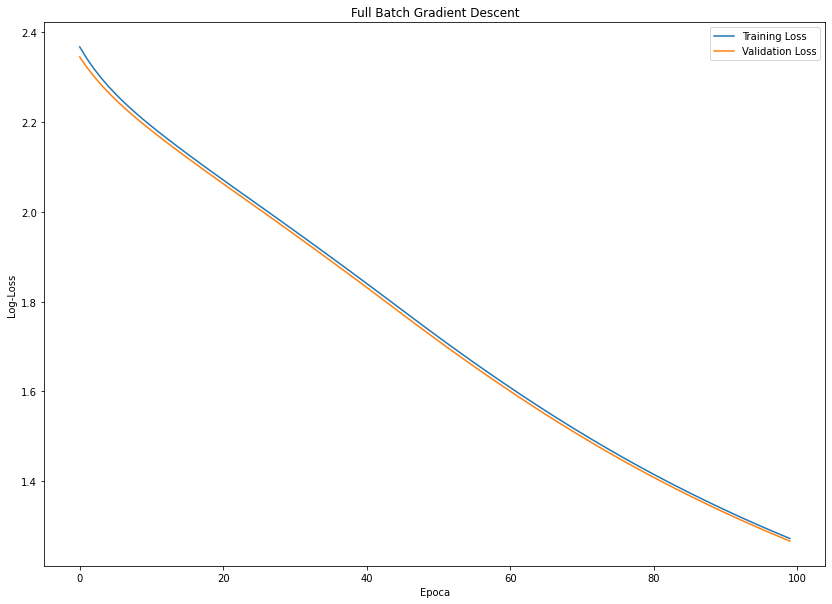

In [ ]:
plot_loss_chart("Full Batch Gradient Descent")

Come possiamo osservare, l'errore del modello si è ridotto in maniera abbastanza pulita senza oscillazioni.

## Stochastic Gradient Descent
Passiamo adesso all'estremo opposto del Gradient Descent: lo Stochastic Gradient Descent che per ogni step utilizza un'unica osservazione.<br> Per utilizzarlo impostiamo come dimensione del singolo batch 1, in modo tale da far utilizzare all'algoritmo di ottimizzazione un esempio per volta. In questo modo il gradient descent ad ogni epoca viene eseguito un numero di volte pari al numero di esempi nel set di addestramento (nel nostro caso 60.000), ne segue che il completamento di un'epoca richiederà molto più tempo rispetto al full batch. Per questo motivo impostiamo il numero di epoche a 5.

In [ ]:
model = build_model()

start_at = time()
model.fit(X_train, y_train, batch_size=1,
          validation_data=(X_test, y_test), validation_batch_size = 1, 
          epochs=10, callbacks=[tf.keras.callbacks.History()])
exec_time = time() - start_at

print("Tempo di addestramento: %d minuti e %d secondi" % (exec_time/60, exec_time%60))

Epoch 1/10
42000/42000 [==============================] - 100s 2ms/step - loss: 0.5436 - accuracy: 0.7988 - val_loss: 0.4942 - val_accuracy: 0.8139
Epoch 2/10
42000/42000 [==============================] - 100s 2ms/step - loss: 0.4112 - accuracy: 0.8475 - val_loss: 0.3893 - val_accuracy: 0.8533
Epoch 3/10
42000/42000 [==============================] - 100s 2ms/step - loss: 0.3694 - accuracy: 0.8640 - val_loss: 0.3502 - val_accuracy: 0.8716
Epoch 4/10
42000/42000 [==============================] - 100s 2ms/step - loss: 0.3421 - accuracy: 0.8717 - val_loss: 0.3748 - val_accuracy: 0.8683
Epoch 5/10
42000/42000 [==============================] - 100s 2ms/step - loss: 0.3232 - accuracy: 0.8798 - val_loss: 0.3445 - val_accuracy: 0.8720
Epoch 6/10
42000/42000 [==============================] - 101s 2ms/step - loss: 0.3068 - accuracy: 0.8843 - val_loss: 0.3935 - val_accuracy: 0.8615
Epoch 7/10
42000/42000 [==============================] - 100s 2ms/step - loss: 0.2946 - accuracy: 0.8889 - val_

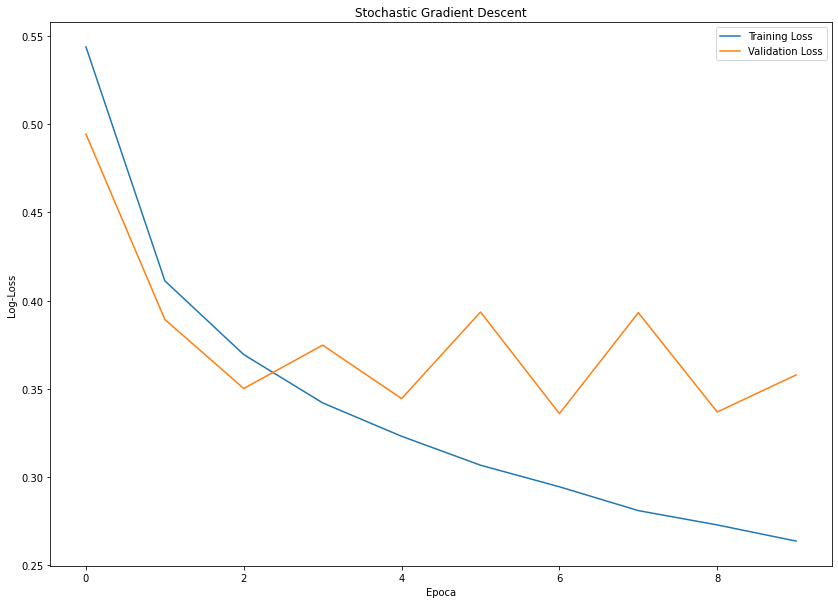

In [ ]:
plot_loss_chart("Stochastic Gradient Descent")

Nel mio caso, l'esecuzione di 5 epoche di stochastic gradient descent ha richiesto 4 volte il tempo del full batch, ma l'addestramento si è concluso con un risultato decisamente migliore.

## Mini Batch Gradient Descent
Completiamo eseguendo la versione intermedia del Gradient Descent e anche quella più consigliata da utilizzare: il Mini Batch Gradient Descent, dove il numero di esempi da utilizzare per ogni step del Gradient Descent viene scelto in numero predefinito.
Specifichiamo all'interno del metodo <span style="font-family: Monaco">fit</span> la dimensione di ogni batch, i valori consigliati sono 32, 64, 128, 256 e 512.<br>
Optiamo per 512.

In [13]:
model = build_model()

start_at = time()
model.fit(X_train, y_train, batch_size=512,
          validation_data=(X_test, y_test), validation_batch_size = 512, 
          epochs=100, callbacks=[tf.keras.callbacks.History()])
exec_time = time() - start_at

print("Tempo di addestramento: %d minuti e %d secondi" % (exec_time/60, exec_time%60))

Epoch 1/100
83/83 [==============================] - 1s 7ms/step - loss: 1.8162 - accuracy: 0.5060 - val_loss: 1.4106 - val_accuracy: 0.6220
Epoch 2/100
83/83 [==============================] - 1s 6ms/step - loss: 1.1533 - accuracy: 0.6836 - val_loss: 1.0071 - val_accuracy: 0.6840
Epoch 3/100
83/83 [==============================] - 1s 6ms/step - loss: 0.8846 - accuracy: 0.7323 - val_loss: 0.8809 - val_accuracy: 0.7017
Epoch 4/100
83/83 [==============================] - 1s 6ms/step - loss: 0.7665 - accuracy: 0.7610 - val_loss: 0.7590 - val_accuracy: 0.7434
Epoch 5/100
83/83 [==============================] - 1s 6ms/step - loss: 0.6972 - accuracy: 0.7788 - val_loss: 0.7525 - val_accuracy: 0.7258
Epoch 6/100
83/83 [==============================] - 1s 6ms/step - loss: 0.6524 - accuracy: 0.7895 - val_loss: 0.6860 - val_accuracy: 0.7683
Epoch 7/100
83/83 [==============================] - 1s 6ms/step - loss: 0.6179 - accuracy: 0.7993 - val_loss: 0.7000 - val_accuracy: 0.7532
Epoch 8/100
8

Il mini batch con un batch size di 512 ha richiesto poco più tempo del full batch e ha portato a un risultato finale decisamente migliore.
Visualizziamo la variazione dell'errore ad ogni epoca.

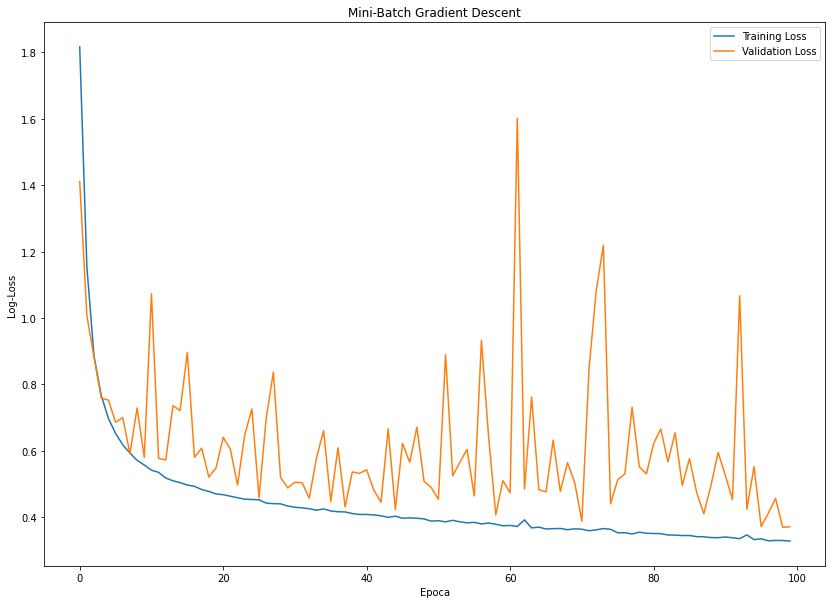

In [16]:
plot_loss_chart("Mini-Batch Gradient Descent")

Come vedi l'errore si è ridotto molto in fretta durante le prime 10 epoche, dopodichè ha continuato a migliorare più lentamento oscillando leggermente.